In [11]:
%matplotlib inline

import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import nltk package
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

# scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

import seaborn as sns

#PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#kmeans
from sklearn.cluster import KMeans

In [12]:
# Download the NLTK English tokenizer and the stopwords of all languages
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jordynohashi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jordynohashi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Prep

In [13]:
directory = os.getcwd()

In [14]:
tweet_dir = os.path.join(directory,'tweets.csv')

In [15]:
tweets = pd.read_csv(tweet_dir, encoding='latin-1')
tweets.columns = ['Polarity', 'ID', 'Date', 'Flag', 'User', 'Text']

In [16]:
tweets.drop(['Flag', 'ID'], axis=1, inplace=True)
tweets.head()

,Polarity,Date,User,Text
0,0,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
1,0,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
3,0,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,@Kwesidei not the whole crew


In [17]:
tweets1 = tweets[0:5000] 
tweets2 = tweets[905000:910000]

# tweets = tweets1.add(tweets2, fill_value=0)

tweets = [tweets1, tweets2]
  
tweets = pd.concat(tweets)

tweets.head()
#tweets.shape

,Polarity,Date,User,Text
0,0,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
1,0,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
3,0,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,@Kwesidei not the whole crew


In [18]:
# re encode positive tweets to 1 instead of 4
def encode(label):
    if label == 0:
        return 0
    elif label == 4:
        return 1

In [19]:
tweets['Polarity'] = tweets.apply(lambda x: encode(x['Polarity']), axis=1)

In [20]:
tweets.head()

,Polarity,Date,User,Text
0,0,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
1,0,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
3,0,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,@Kwesidei not the whole crew


## BoW Vectorizer

In [21]:
cvectorizer = CountVectorizer(analyzer='word', max_features=2000, 
                             tokenizer=word_tokenize, stop_words= stopwords.words('english'))

In [22]:
df_count_Y = np.array(tweets['Polarity'])
df_count_Y.shape

(10000,)

In [52]:
# vocabulary
cvectorizer.fit(tweets["Text"])
print("Unique words: ", cvectorizer.vocabulary_)

Unique words:  {'upset': 1843, 'ca': 319, "n't": 1216, 'update': 1836, 'facebook': 646, '...': 22, 'might': 1158, 'cry': 459, 'school': 1500, 'today': 1764, 'also': 128, '.': 20, 'blah': 258, '!': 0, '@': 73, 'many': 1132, 'times': 1758, 'ball': 212, 'managed': 1130, 'save': 1492, '50': 57, '%': 3, 'rest': 1452, 'go': 777, 'whole': 1916, 'body': 269, 'feels': 674, 'itchy': 960, 'like': 1067, 'fire': 698, ',': 17, "'s": 11, "'m": 9, 'mad': 1118, '?': 72, 'see': 1510, 'need': 1229, 'hug': 911, 'hey': 870, 'long': 1091, 'time': 1757, 'yes': 1984, '..': 21, 'bit': 255, 'lol': 1088, 'fine': 692, 'thanks': 1732, 'nope': 1249, 'que': 1403, 'spring': 1626, 'break': 289, 'city': 380, 'snowing': 1589, 'could': 436, 'bear': 228, 'watch': 1888, 'thought': 1746, 'loss': 1100, 'idk': 927, 'either': 590, 'never': 1235, 'talk': 1705, 'anymore': 143, 'would': 1958, "'ve": 12, 'first': 699, 'really': 1428, 'though': 1745, 'wish': 1926, 'got': 794, 'miss': 1172, 'premiere': 1379, "'": 5, 'death': 500, 'h

In [49]:
df_count_X = cvectorizer.transform(tweets["Text"]).toarray()
df_count_X

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0]])

In [25]:
df_train_count_X, df_test_count_X, df_train_count_Y, df_test_count_Y = train_test_split(df_count_X, df_count_Y, test_size= .2, random_state= 200)


## TF-IDF Vectorizer

In [27]:
tfidf = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=2000,tokenizer=word_tokenize)

In [28]:
df_tfidf_Y = np.array(tweets['Polarity'])
df_tfidf_Y.shape

(10000,)

In [29]:
# vocabulary
tfidf.fit(tweets["Text"])
print("Unique words: ", tfidf.vocabulary_)

Unique words:  {'is': 941, 'upset': 1831, 'that': 1710, 'he': 830, 'ca': 319, "n't": 1201, 'update': 1825, 'his': 860, 'facebook': 630, 'by': 316, 'it': 945, '...': 22, 'and': 131, 'might': 1141, 'cry': 450, 'as': 166, 'a': 70, 'result': 1438, 'school': 1481, 'today': 1751, 'also': 122, '.': 20, 'blah': 260, '!': 0, '@': 65, 'i': 906, 'many': 1114, 'times': 1744, 'for': 704, 'the': 1712, 'ball': 209, 'managed': 1112, 'to': 1749, 'save': 1473, '50': 53, '%': 3, 'rest': 1437, 'go': 760, 'out': 1286, 'of': 1247, 'my': 1197, 'whole': 1909, 'body': 268, 'feels': 658, 'itchy': 948, 'like': 1051, 'its': 949, 'on': 1262, 'fire': 681, 'no': 1227, ',': 17, "'s": 11, 'not': 1234, 'at': 176, 'all': 112, "'m": 9, 'mad': 1101, 'why': 1911, 'am': 125, 'here': 850, '?': 64, 'because': 231, 'see': 1490, 'you': 1985, 'over': 1289, 'there': 1717, 'need': 1212, 'hug': 894, 'hey': 853, 'long': 1073, 'time': 1743, 'yes': 1981, '..': 21, 'bit': 257, 'only': 1268, 'lol': 1070, 'fine': 676, 'thanks': 1708, 'ho

In [30]:
df_tfidf_X = tfidf.transform(tweets["Text"]).toarray()
df_tfidf_X.shape
# should be (10000, 2000)

(10000, 2000)

In [31]:
df_train_tfidf_X, df_test_tfidf_X, df_train_tfidf_Y, df_test_tfidf_Y = train_test_split(df_tfidf_X, df_tfidf_Y, test_size= .2, random_state= 200)


## PCA & K-means w/ BoW

In [32]:
#scale data
scaler = StandardScaler()
df_count_X_scale = scaler.fit_transform(df_count_X)
# df_test_count_X_scale = scaler.fit_transform(df_test_count_X)

In [33]:
pca = PCA(2)
pca_count = pca.fit_transform(df_count_X_scale)

In [34]:
kmeans = KMeans(n_clusters=2, max_iter=400, algorithm = 'auto')
# fitting kmeans model
fitted_count = kmeans.fit(pca_count)

#predicting clusters
prediction_count = kmeans.predict(pca_count)

In [35]:
prediction_count.shape

(10000,)

In [36]:
target_names = ['negative', 'positive']
print(classification_report(df_count_Y,prediction_count,target_names=target_names))

              precision    recall  f1-score   support

    negative       0.51      0.95      0.66      5000
    positive       0.59      0.07      0.12      5000

    accuracy                           0.51     10000
   macro avg       0.55      0.51      0.39     10000
weighted avg       0.55      0.51      0.39     10000



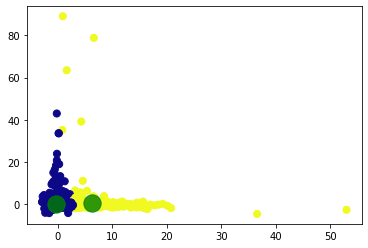

In [37]:
# Plotting scatter plot
plt.scatter(pca_count[:, 0], pca_count[:, 1],c=prediction_count ,s=50, cmap='plasma')  
center2_count = fitted_count.cluster_centers_ 
plt.scatter(center2_count[:, 0], center2_count[:, 1],c='green', s=300, alpha=0.8)


In [38]:
df_count_pca = PCA().fit(df_count_X_scale)

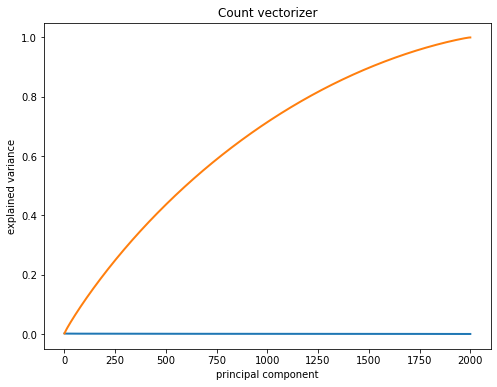

In [39]:
fig, ax = plt.subplots(figsize=(8,6))

x_values = range(1, df_count_pca.n_components_+1)

ax.plot(x_values, df_count_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(df_count_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('Count vectorizer')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

## PCA & K-means w/ TD-IDF

In [40]:
#scale data
scaler = StandardScaler()
df_tfidf_X_scale = scaler.fit_transform(df_tfidf_X)
# df_test_tfidf_X_scale = scaler.fit_transform(df_test_tfidf_X)

In [41]:
pca = PCA(2)
pca_tfidf = pca.fit_transform(df_tfidf_X_scale)

In [42]:
kmeans = KMeans(n_clusters=2, max_iter=400, algorithm = 'auto')
# fitting kmeans model
fitted_tfidf = kmeans.fit(pca_tfidf)

#predicting clusters
prediction_tfidf = kmeans.predict(pca_tfidf)

In [43]:
prediction_tfidf.shape

(10000,)

In [44]:
target_names = ['negative', 'positive']
print(classification_report(df_tfidf_Y,prediction_tfidf,target_names=target_names))

              precision    recall  f1-score   support

    negative       0.50      0.95      0.66      5000
    positive       0.58      0.07      0.12      5000

    accuracy                           0.51     10000
   macro avg       0.54      0.51      0.39     10000
weighted avg       0.54      0.51      0.39     10000



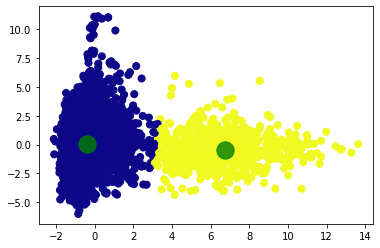

In [45]:
# Plotting scatter plot
plt.scatter(pca_tfidf[:, 0], pca_tfidf[:, 1],c=prediction_tfidf ,s=50, cmap='plasma')  
center2_tfidf = fitted_tfidf.cluster_centers_ 
plt.scatter(center2_tfidf[:, 0], center2_tfidf[:, 1],c='green', s=300, alpha=0.8)


In [46]:
df_tdidf_pca = PCA().fit(df_tfidf_X_scale)

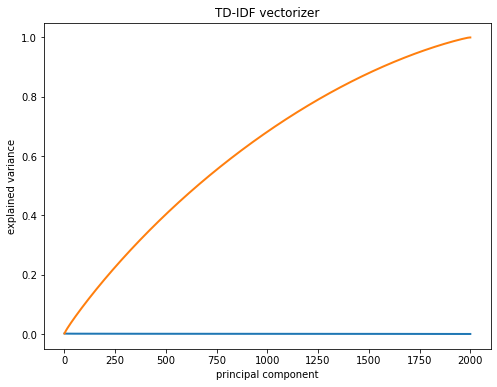

In [47]:
fig, ax = plt.subplots(figsize=(8,6))

x_values = range(1, df_tdidf_pca.n_components_+1)

ax.plot(x_values, df_tdidf_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(df_tdidf_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('TD-IDF vectorizer')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

## SVM Linear w/ BoW

In [48]:
def train_SVM(X, y, kernel='linear'):
    clf = SVC(kernel=kernel)
    clf.fit(X, y)
    return clf

In [40]:
df_count_clf = train_SVM(df_train_count_X, df_train_count_Y)

In [41]:
# df_pred_train_count_Y = df_count_clf.predict(df_train_count_X)
df_pred_test_count_Y = df_count_clf.predict(df_test_count_X)

In [42]:
target_names = ['negative', 'positive']
print(classification_report(df_test_count_Y,df_pred_test_count_Y,target_names=target_names))


              precision    recall  f1-score   support

    negative       0.73      0.71      0.72      1003
    positive       0.72      0.74      0.73       997

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.72      2000
weighted avg       0.73      0.72      0.72      2000



## SVM Linear w/ TF-IDF

In [43]:
df_tfidf_clf = train_SVM (df_train_tfidf_X, df_train_tfidf_Y)

In [44]:
df_pred_train_tfidf_Y = df_tfidf_clf.predict(df_train_tfidf_X)
df_pred_test_tfidf_Y = df_tfidf_clf.predict(df_test_tfidf_X)

In [45]:
target_names = ['negative', 'positive']
print(classification_report(df_test_tfidf_Y, df_pred_test_tfidf_Y,target_names=target_names))

              precision    recall  f1-score   support

    negative       0.75      0.75      0.75      1003
    positive       0.75      0.75      0.75       997

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



In [46]:
# Draw the heatmap of training errors.
def draw_heatmap(training_errors):
    # training_errors: A NumPy array with the shape (len(C_list), len(gamma_list))
    # gamma_list: List of gamma(s).
    # C_list: List of C(s).
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f', 
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel = '$\gamma$', ylabel='$C$')
    plt.title('Training error w.r.t $C$ and $\gamma$')
    plt.show()

## SVM Non-linear (RBF) w/ TF-IDF

In [ ]:
# takes too long to train

# C_list = [1, 10, 100, 1000, 10000]
# gamma_list = [1e-6, 1e-5, 1e-4, 1e-3,1e-2]
# classifier = svm.SVC(kernel='rbf')
# search_results =  GridSearchCV(classifier, {'C':C_list, 'gamma': gamma_list, 'kernel': ['rbf']}) #########

# search_results.fit(df_train_count_X,df_train_count_Y)

In [ ]:
# here's how we can extract all the same information from the search_results data structure

# first get the parameters used in the order they were used
results = pd.DataFrame( search_results.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results['score'] = 1 - search_results.cv_results_['mean_test_score']

# turn a long table into a 2-D table with C being the 1st axis (y-axis) and gamma as the 2nd (x-axis)
results = results.pivot('C','gamma','score')

# and plot it
# using the dataframe means we don't need the wrapper fct around sns.heatmap we used before
sns.heatmap(results,annot=True, fmt='.3f') 
plt.title('Training error w.r.t $C$ and $\gamma$')
plt.show()

In [ ]:
# extract the best estimator and its params
opt_classifier = search_results.best_estimator_
opt_C = search_results.best_params_['C']
opt_gamma = search_results.best_params_['gamma']

# just a copy/paste of test set evaluation from before
opt_classifier.fit(df_train_count_X,df_train_count_Y)
opt_test_score = 1 - opt_classifier.score(df_test_count_X,df_test_count_Y) # again turn accuracy into misclassification error
print(f'Test set error for optimum classifier(C={opt_C},gamma={opt_gamma}): {opt_test_score:.3f}') 
